<img src='media/capy.gif' align='center' width="200px">

# Анализ еды в Перекрёстке

**Тема**: Анализ продуктов питания [Перекрестка](https://www.perekrestok.ru)

**Основная цель**: Выяснить, есть ли зависимость между описанием, составом товара и ценой

**Команда**: Перек✩

In [639]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import parcer

## Cбор данных

Начнем сбор данных со [страницы каталога](https://www.perekrestok.ru/cat), постепенно углубляясь

Все функции парсинга находятся в `parcer.py`

**Шаг 1** \
Собираем все категории товаров, и ссылки на них

In [3]:
cats = parcer.parce_cats("https://www.perekrestok.ru/cat") # /ᐠ｡ꞈ｡ᐟ\
cats[0]

['Все на дачу', '/cat/mc/1181/vse-na-dacu']

Уберем категории, которые не относятся к продуктам питания

In [8]:
undesired_cats = [
    'Все на дачу',
    'Зоотовары',
    'Для дома и дачи',
    'Красота, гигиена, аптека',
    'Уборка',
    'Товары для мам и детей',
    'Системы нагревания, табак',
    'Посуда',
]

cats = [cat for cat in cats if cat[0] not in undesired_cats]

**Шаг 2** \
По ссылкам на категории, собираем подкатегории и ссылки на подкатегории

In [10]:
subcats = parcer.parce_subcats(cats)
subcats[0]

('Зелёная Линия', 'От Перекрёстка', '/cat/c/284/zelenaa-linia')

Уберем подкатегории, которые не относятся к продуктам питания

In [11]:
undesired_subcats = [
    'Home Story',
    'Kokoro',
    'Honey Kid',
]

subcats = [subcat for subcat in subcats if subcat[0] not in undesired_subcats]

**Шаг 3** \
Теперь благодаря ссылкам на подкатегории мы можем собрать все листинги. В листингах есть ссылки на товары, а также поверхностная информация

In [34]:
listing_products = parcer.parce_listing_products(subcats)
listing_products[0]

['Томаты черри на ветке, 250г',
 '/cat/150/p/tomaty-cerri-na-vetke-250g-3673307',
 'От Перекрёстка',
 'Маркет',
 '4.92',
 '250 гр',
 '179,99 ₽/шт',
 '179,99 ₽',
 '219,99 ₽',
 '-18%',
 '/cat/c/287/market']

In [72]:
parcer.save_listing_products_to_csv('data/listing_products.csv', listing_products)

Список успешно сохранен в файл data/listing_products.csv


**Шаг 4** \
Проходимся по ссылкам из листингов и получаем полную информацию о каждом товаре

In [75]:
products = parcer.parce_products(listing_products)
products[0]

['/cat/150/p/tomaty-cerri-na-vetke-250g-3673307',
 'Томаты черри на ветке, 250г',
 17999,
 '-18%',
 492,
 '15.0',
 '0.8 г',
 '0.1 г',
 '2.8 г',
 'Томаты.',
 'ТД Самарканд Агро',
 'Маркет',
 'Россия',
 '30 дней',
 '15 ℃',
 '5 ℃']

In [67]:
parcer.save_products_to_csv('data/products.csv', products)

Список успешно сохранен в файл data/products.csv


**Итог** \
В файлах *listing_products.csv* и *products.csv* мы собрали информацию о всех товарах в нужных категориях

*listing_products.csv* \
`name` - Название товара \
`href` - Ссылка на товар \
`rating` - Рейтинг товара от 0.00 до 5.00 \
`size` - Вес товара в гр \
`price` - Расценка товара (x/шт или x/кг) \
`new_price` - Цена товара \
`old_price` - Цена без скидки \
`discount` - Скидка или специальное предложение \
`subcat_href` - Ссылка на подкатегорию \
`cat` - Категория товара \
`subcat` - Подкатегория товара 

*products.csv* \
`title` - Название товара \
`product_href` - Ссылка на товар \
`price` - Цена товара \
`discount` - Скидка или специальное предложение \
`rating` - Рейтинг товара от 0.00 до 5.00 \
`kalories` - Калории на 100г \
`proteins` - Белки на 100г \
`fats` - Жиры на 100г \
`carbohydrates` - Углеводы на 100г \
`composition` - Состав продукта \
`manufacturer` - Производитель \
`brand` - Бренд \
`country` - Страна \
`shelf_life` - Срок хранения в днях \
`max_storage_temperature` - Температура хранения макс. \
`min_storage_temperature` - Температура хранения мин.


## Предварительная обработка

**Шаг 1** \
Соединим собранные данные, удалим лишние столбцы

In [640]:
listing_products_df = pd.read_csv("data/listing_products.csv")
products_df = pd.read_csv("data/products.csv")

df = pd.merge(
    products_df,
    listing_products_df,
    left_on="product_href",
    right_on="href",
    how="left",
)
df = df.drop(
    ["price_x", "discount_x", "title", "product_href", "subcat_href", "rating_x"],
    axis=1,
)

Переименуем столбцы после слияния и отсортируем

In [641]:
new_names = {
    "rating_y": "rating",
    "price_y": "pricing",
    "discount_y": "discount",
    "new_price": "price",
    "cat": "category",
    "subcat": "subcategory",
}

df = df.rename(columns=new_names)

new_order = [
    "name",
    "category",
    "subcategory",
    "href",
    "kalories",
    "proteins",
    "fats",
    "carbohydrates",
    "composition",
    "manufacturer",
    "brand",
    "country",
    "rating",
    "size",
    "pricing",
    "price",
    "old_price",
    "discount",
    "shelf_life",
    "max_storage_temperature",
    "min_storage_temperature",
]

df = df.reindex(columns=new_order)

В некоторых категориях товары дублировались, исправим

In [642]:
df.drop_duplicates(inplace=True, subset=['href', 'name'])
df.dropna(subset=['href'], inplace=True)
df = df.drop(['href'], axis=1) # Удаляем больше не нужную колонку
df = df.reset_index(drop=True)
df.head()

,name,category,subcategory,kalories,proteins,fats,carbohydrates,composition,manufacturer,brand,country,rating,size,pricing,price,old_price,discount,shelf_life,max_storage_temperature,min_storage_temperature
0,Вино Мысхако Quintessence Zinfandel красное по...,Алкогольные напитки,Вино,95.0,0.0 г,0.0 г,0.6 г,"Виноград сорта Зинфандель, пищевая добавка (ко...",Мысхако,Мысхако,Россия,4.89,750 мл,"899,99 ₽/шт","899,99 ₽","899,99 ₽",3 по цене 2-х,9999 дней,20 ℃,5 ℃
1,"Вино Takar Арени красное сухое 14%, 750мл",Алкогольные напитки,Вино,74.0,0.0 г,0.0 г,0.3 г,Виноград сорта Арени; пищевая добавка (консерв...,Armenia Wine,Takar,Армения,4.90,750 мл,"699,99 ₽/шт","699,99 ₽","899,99 ₽",-22%,9999 дней,NaN,5 ℃
2,"Вино Terras de Pegoes красное сухое 12.5%, 750мл",Алкогольные напитки,Вино,75.0,0.0 г,0.0 г,0.1 г,"Сортовой состав винограда: Каштелао - 60%, Али...",Cooperativa Agrícola de Santo Isidro De Pegões,Pegoes,Португалия,4.78,750 мл,"499,99 ₽/шт","499,99 ₽","699,99 ₽",-28%,9999 дней,NaN,NaN
3,"Вино Highway to Hell красное сухое 13%, 750мл",Алкогольные напитки,Вино,79.0,0.0 г,0.0 г,0.0 г,"Виноград сорта Монастрель, пищевая добавка (ко...",Wines N'Roses,Highway to Hell,Испания,4.81,750 мл,"1 099,00 ₽/шт","1 099,00 ₽",NaN,Нет скидки,9999 дней,NaN,5 ℃
4,"Вино Don Garcia красное сухое 11%, 1л",Алкогольные напитки,Вино,0.0,0.0 г,0.0 г,0.0 г,"Красные сорта винограда, пищевая добавка (конс...",J. Garcia Carrion,Don Garcia,Испания,4.75,1000 мл,"549,99 ₽/шт","549,99 ₽",NaN,Нет скидки,9999 дней,20 ℃,5 ℃


**Шаг 2** \
Проверим есть ли пропуски в датасете

In [643]:
df.isnull().sum()

name                          0
category                      0
subcategory                   0
kalories                    267
proteins                    308
fats                        308
carbohydrates               313
composition                 332
manufacturer                398
brand                       532
country                     238
rating                        0
size                        692
pricing                       0
price                         0
old_price                  8989
discount                      0
shelf_life                    0
max_storage_temperature    3777
min_storage_temperature    4627
dtype: int64

Уберем товары не относящиеся к продуктам питания, которые попали в датасет из-за смешанных категорий. \
Для этого найдем все товары с пустыми `kalories` и исключим из них продукты питания

In [644]:
non_food_ids = (df["kalories"].isnull()) & (
    ~df["subcategory"].isin(
        [
            "Кофе",
            "Чай",
            "Специи, приправы и пряности",
            "Соль",
            "Вся рыба",
            "Охлаждённая рыба",
            "Копчёная рыба",
            "Вяленая рыба",
            "Вода",
            "Пиво",
            "Конфеты",
            "Компоненты для выпечки",
            "Молочные коктейли",
            "Полуфабрикаты",
            "Овощи",
            "Фрукты",
            "Зелень и салаты",
            "Коньяк",
        ]
    )
)

non_food = df[non_food_ids][["name", "subcategory"]]
df = df[~non_food_ids]

non_food.iloc[5]

name           Губка Волна для обуви и изделий из кожи бесцве...
subcategory                                               Маркет
Name: 6154, dtype: object

Все остальные пропуски `kalories` заполняем нулями

In [645]:
df.loc[df['kalories'].isnull(), 'kalories'] = 0

**Шаг 3** \
Преобразовываем в тип float и заполняем нулями все пропуски `proteins`, `fats` и `carbohydrates`

In [646]:
df.loc[:, 'proteins'] = df['proteins'].str.replace(' г', '').astype(float)
df.loc[:, 'fats'] = df['fats'].str.replace(' г', '').astype(float)
df.loc[:, 'carbohydrates'] = df['carbohydrates'].str.replace(' г', '').astype(float)

df.loc[df['proteins'].isnull(), 'proteins'] = 0
df.loc[df['fats'].isnull(), 'fats'] = 0
df.loc[df['carbohydrates'].isnull(), 'carbohydrates'] = 0

**Шаг 4** \
Так как у нас нет информации о средней плотности всех напитков, в колонке `size` неявно приравняем **мл** к **гр**, переводим во float

In [647]:
df.loc[:, "size"] = (
    df["size"]
    .str.replace(" гр", "")
    .str.replace(" мл", "")
    .str.replace(" ", "")
    .astype(float)
)

Расценка `pricing` у товаров на развес 🥒 указывается не за **шт**, а за **кг**, поэтому `size` в этих строках пустой. \
Заполным эти пропуски как 1000 гр, а также создадим **новый признак** `is_by_weight`, в котором укажем на развес ли продукт
<a id='is_by_weight'></a>

In [648]:
pricing_units = df["pricing"].str.split("/").str[1]
pricing_units.unique()

array(['шт', 'кг'], dtype=object)

In [649]:
df.loc[pricing_units == "кг", "size"] = 1000
df["is_by_weight"] = 1 * (pricing_units == "кг")

Далее `pricing` нам не понадобится, так как есть, `price`

In [650]:
df = df.drop(['pricing'], axis=1) 

Отформатируем `price` и `old_price`

In [651]:
df.loc[:, "price"] = (
    df["price"]
    .str.replace(" ₽", "")
    .str.replace(",", ".")
    .str.replace(" ", "")
    .astype(float)
)
df.loc[:, "old_price"] = (
    df["old_price"]
    .str.replace(" ₽", "")
    .str.replace(",", ".")
    .str.replace(" ", "")
    .astype(float)
)

У товаров без скидки свойство `old_price` пропущено, прировняем к `price`

In [652]:
null_old_prices = df['old_price'].isnull()
df.loc[null_old_prices, 'old_price'] = df[null_old_prices]['price']

**Шаг 5** \
Преобразовываем скидку во float, для специальных предложений создаем **новый признак** `is_special_offer`
<a id='is_special_offer'></a>

In [653]:
df['discount'].unique()

array(['3 по цене 2-х', '-22%', '-28%', 'Нет скидки', '-25%', '-33%',
       '-16%', '-18%', '-41%', '-17%', '-26%', '-43%', '-15%', '-19%',
       '-31%', '-23%', '-44%', '-57%', '-36%', '-37%', '-40%', '-30%',
       '-24%', '-47%', '-55%', '-27%', '-21%', '-49%', '-14%', '-45%',
       '-11%', '-56%', '-48%', 'Новинка', '-20%', '-32%', '-52%', '-38%',
       '-50%', '-29%', '-13%', '-10%', '-39%', '-35%', '-46%', '-12%',
       'Низкая цена', '-58%', '-34%', '-54%', '-42%', '-65%', '-62%',
       '-59%', '-53%', '-63%', '-70%', '-51%', '5 по цене 4-х',
       '2 по цене 1-го', '-60%', '4 по цене 3-х', '-77%'], dtype=object)

In [654]:
is_special_offer = df["discount"].isin(
    [
        "3 по цене 2-х",
        "Новинка",
        "Низкая цена",
        "5 по цене 4-х",
        "2 по цене 1-го",
        "4 по цене 3-х",
    ]
)

is_no_discount = df["discount"].isin(["Нет скидки"])

df.loc[:, "discount"] = df["discount"].str.replace("-", "").str.replace("%", "")
df.loc[is_special_offer + is_no_discount, "discount"] = 0
df.loc[:, "discount"] = df["discount"].astype(float)

df["is_special_offer"] = is_special_offer

**Шаг 6** \
Приводим к типу float `shelf_life`, `max_storage_temperature` и `min_storage_temperature`

In [655]:
df.loc[:, "shelf_life"] = (
    df["shelf_life"]
    .str.replace(" дней", "")
    .str.replace(" день", "")
    .str.replace(" дня", "")
    .astype(float)
)
df.loc[:, "max_storage_temperature"] = (
    df["max_storage_temperature"].str.replace(" ℃", "").astype(float)
)
df.loc[:, "min_storage_temperature"] = (
    df["min_storage_temperature"].str.replace(" ℃", "").astype(float)
)

У некоторых товаров значения максимальной и минимальной температуры хранения перепутаны, исправим

In [656]:
mis_tems = df['max_storage_temperature'] < df['min_storage_temperature']

df.loc[mis_tems, ['max_storage_temperature', 'min_storage_temperature']] = \
    df.loc[mis_tems, ['min_storage_temperature', 'max_storage_temperature']].values

Считаем пропуски как неограниченную температуру хранения. \
Заполняем максимальной для `max_storage_temperature` (не учитывая единственного выброса 🍾 в 9999), минимальной для `min_storage_temperature` 

In [657]:
sorted(df['max_storage_temperature'].dropna().unique())[-3:]

[40.0, 50.0, 9999.0]

In [658]:
sorted(df['min_storage_temperature'].dropna().unique())[:3]

[-40.0, -30.0, -26.0]

In [659]:
df[df['max_storage_temperature'] == 9999]

,name,category,subcategory,kalories,proteins,fats,carbohydrates,composition,manufacturer,brand,...,rating,size,price,old_price,discount,shelf_life,max_storage_temperature,min_storage_temperature,is_by_weight,is_special_offer
4531,"Коньяк Старая Площадь КВ выдержанный 40%, 500мл",Алкогольные напитки,Коньяк,230.0,0.0,0.0,1.2,Дистилляты коньячные выдержанные не менее сем...,Мосазервинзавод,СТАРАЯ ПЛОЩАДЬ,...,0.0,500.0,779.99,779.99,0.0,9999.0,9999.0,5.0,0,False


In [660]:
max_mask = (df['max_storage_temperature'] == 9999) + df['max_storage_temperature'].isnull()
df.loc[max_mask, 'max_storage_temperature'] = 50.0

min_mask = df['min_storage_temperature'].isnull()
df.loc[min_mask, 'min_storage_temperature'] = -40.0

**Шаг 7** \
Заполним пропуски в `manufacturer`, `brand` и `country` как "Unknown"

In [661]:
df['manufacturer'] = df['manufacturer'].fillna('Unknown')
df['brand'] = df['brand'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')

**Шаг 8** \
У некоторых товаров состав пропущен или состоит из заглушки в виде "." или "/". Заполним как "Unknown"

In [662]:
df['composition'] = df['composition'].fillna('Unknown')
df.loc[df['composition'] == ".", 'composition'] = 'Unknown'
df.loc[df['composition'] == "/", 'composition'] = 'Unknown'

Обновляем тип колонок в df и проверяем пропуски

In [663]:
numeric_cols = [
    "proteins",
    "fats",
    "carbohydrates",
    "size",
    "price",
    "old_price",
    "discount",
    "shelf_life",
    "max_storage_temperature",
    "min_storage_temperature",
]
df[numeric_cols] = df[numeric_cols].astype(float)
df.isnull().sum()

name                       0
category                   0
subcategory                0
kalories                   0
proteins                   0
fats                       0
carbohydrates              0
composition                0
manufacturer               0
brand                      0
country                    0
rating                     0
size                       0
price                      0
old_price                  0
discount                   0
shelf_life                 0
max_storage_temperature    0
min_storage_temperature    0
is_by_weight               0
is_special_offer           0
dtype: int64

**Выбросы** \
С `max_storage_temperature` мы справились, посмотрим остальные

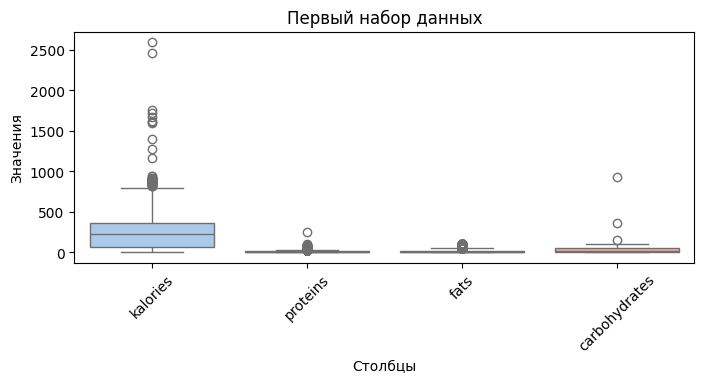

In [664]:
plt.figure(figsize=(8, 3))
sns.boxplot(data=df[['kalories', 'proteins', 'fats', 'carbohydrates']])
plt.title('Первый набор данных')
plt.xlabel('Столбцы')
plt.ylabel('Значения')
plt.xticks(rotation=45)
plt.show()

Разбираемся с супер-белковым мороженым и супер-калорийными хлебцами

In [665]:
x10_outliers = df['kalories'] > 1100
print(df[x10_outliers][['name', 'kalories']].iloc[4])
df.loc[x10_outliers, 'kalories'] = df['kalories'][x10_outliers] / 10

name        Хлебцы Magic Grain мультизлаковые тыквенные се...
kalories                                               1610.0
Name: 9031, dtype: object


In [666]:
vodka_outliers = df['kalories'] > 919
print(df[vodka_outliers][['name', 'kalories']])
df.loc[vodka_outliers, 'kalories'] = df['kalories'][vodka_outliers] / (df['size'][vodka_outliers]/100)

                                                   name  kalories
3890           Сыр Pretto творожный с огурцом 65%, 140г     942.6
6910                       Водка Гусь Важный 40%, 500мл     920.0
7044  Водка Kremlin Award Органик Лимитед Эдишн 40%,...     940.0


In [667]:
icecream_outliers = df['proteins'] > 249
print(df[icecream_outliers][['name', 'proteins']])
df.loc[icecream_outliers, 'proteins'] = df['proteins'][icecream_outliers] / 10

                                                    name  proteins
11611  Мороженое сливочное Brand Ice Сливки с печенье...     250.0


In [668]:
fats_outliers = df['fats'] > 105
print(df[fats_outliers][['name', 'fats']])
df.loc[fats_outliers, 'fats'] = df['fats'][fats_outliers] / 10

                                     name   fats
5863  Гранола Ягодная Зелёная Линия, 300г  106.0


In [669]:
icecream_outliers = df['carbohydrates'] > 105
print(df[icecream_outliers][['name', 'carbohydrates']])
df.loc[icecream_outliers, 'carbohydrates'] = df['carbohydrates'][icecream_outliers] / 10

                                      name  carbohydrates
3619            Сыр Киприно Российский 50%          360.0
6405                 Водка CORN 40%, 500мл          930.0
10393  Конфеты ассорти Зелёная Линия, 200г          153.3


<img src='media/milk.gif' align='center' width="200px">

**Итог** \
В данных нет пропусков, они отформатированы и очищены от выбросов

In [670]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12399 entries, 0 to 12598
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     12399 non-null  object 
 1   category                 12399 non-null  object 
 2   subcategory              12399 non-null  object 
 3   kalories                 12399 non-null  float64
 4   proteins                 12399 non-null  float64
 5   fats                     12399 non-null  float64
 6   carbohydrates            12399 non-null  float64
 7   composition              12399 non-null  object 
 8   manufacturer             12399 non-null  object 
 9   brand                    12399 non-null  object 
 10  country                  12399 non-null  object 
 11  rating                   12399 non-null  float64
 12  size                     12399 non-null  float64
 13  price                    12399 non-null  float64
 14  old_price                12

## Визуализация

Посмотрим на распределение переменной, которую будем предсказывать

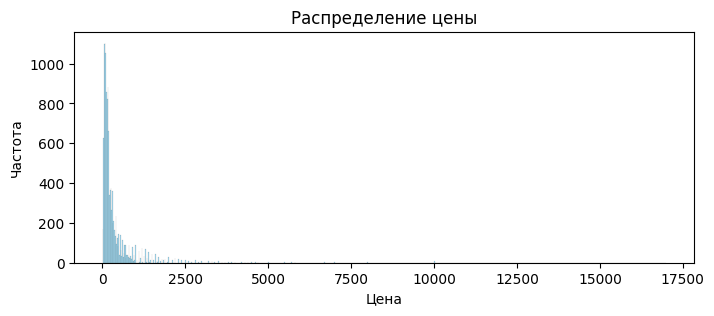

In [671]:
plt.figure (figsize = (8, 3))
sns.histplot(df['price'], color='skyblue')
plt.title('Распределение цены')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

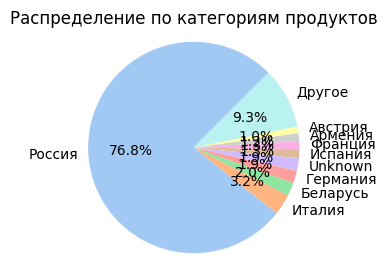

In [672]:
threshold_percentage = 0.8

category_counts = df['country'].value_counts()

small_categories_sum = category_counts[category_counts / category_counts.sum() * 100 < threshold_percentage].sum()
category_counts = category_counts[category_counts / category_counts.sum() * 100 >= threshold_percentage]
category_counts['Другое'] = small_categories_sum

plt.figure(figsize=(3, 3))
sns.set_palette("pastel") 
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=45)
plt.title('Распределение по категориям продуктов')
plt.axis('equal')
plt.show()

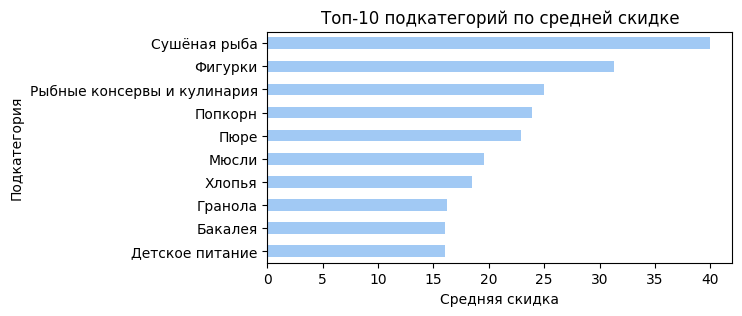

In [673]:
mean_discount_by_subcategory = df.groupby('subcategory')['discount'].mean()

top_10_discount_by_subcategory = mean_discount_by_subcategory.sort_values(ascending=False).head(10)

plt.figure(figsize=(6, 3)) 
top_10_discount_by_subcategory.plot(kind='barh')
plt.title('Топ-10 подкатегорий по средней скидке')
plt.xlabel('Средняя скидка')
plt.ylabel('Подкатегория')
plt.gca().invert_yaxis()
plt.show()

Похоже, что скидки появляются чаще у товаров с большим сроком хранения

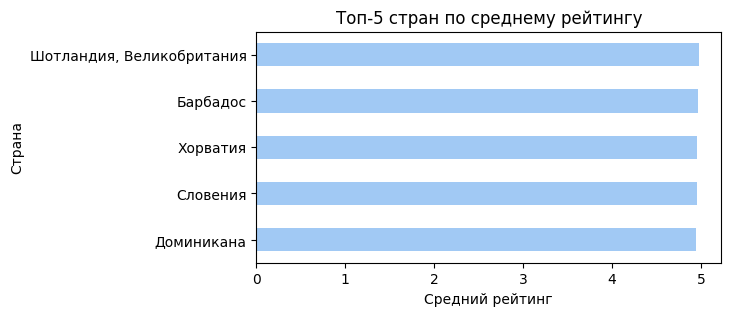

In [674]:
mean_rating_by_country = df.groupby('country')['rating'].mean()

top_15_rating_by_country = mean_rating_by_country.sort_values(ascending=False).head(5)

plt.figure(figsize=(6, 3))
top_15_rating_by_country.plot(kind='barh')
plt.title('Топ-5 стран по среднему рейтингу')
plt.xlabel('Средний рейтинг')
plt.ylabel('Страна')
plt.gca().invert_yaxis()
plt.show()

<Axes: >

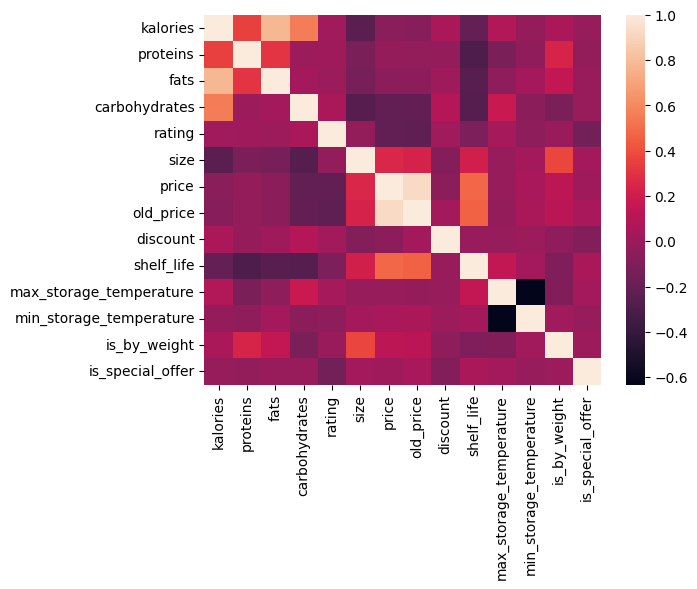

In [675]:
numeric_df = df.drop(['name', 'category', 'subcategory', 'composition', 'manufacturer', 'brand', 'country'], axis=1)
sns.heatmap(numeric_df.corr())

Помимо нескольких закономерных корреляций, как например калории и БЖУ, интересно что присутствует связь между сроком годности и ценой, а также чуть более слабая связь между белками и товаром на развес.

Посмотрим на самые калорийные продукт


<Figure size 1200x800 with 0 Axes>

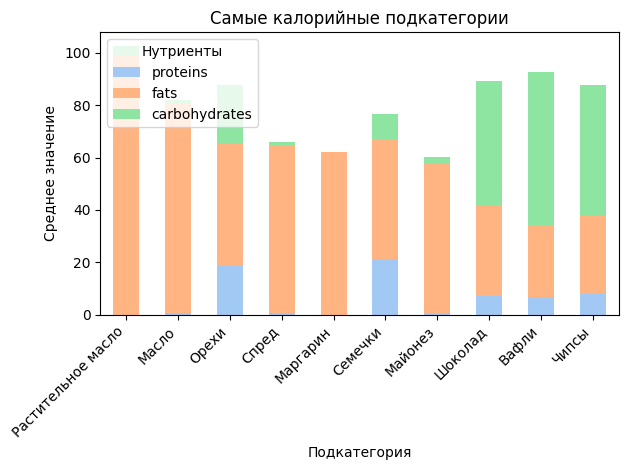

In [676]:
nutrients_by_subcategory = df.groupby('subcategory')[['kalories', 'proteins', 'fats', 'carbohydrates']] \
    .mean().sort_values(by='kalories', ascending=False)[['proteins', 'fats', 'carbohydrates']].head(10)

plt.figure(figsize=(12, 8))
nutrients_by_subcategory.plot(kind='bar', stacked=True)
plt.title('Самые калорийные подкатегории')
plt.xlabel('Подкатегория')
plt.ylabel('Среднее значение')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Нутриенты', loc='upper left')
plt.tight_layout()
plt.show()

Посмотрим на самые белковые продукты

<Figure size 1200x800 with 0 Axes>

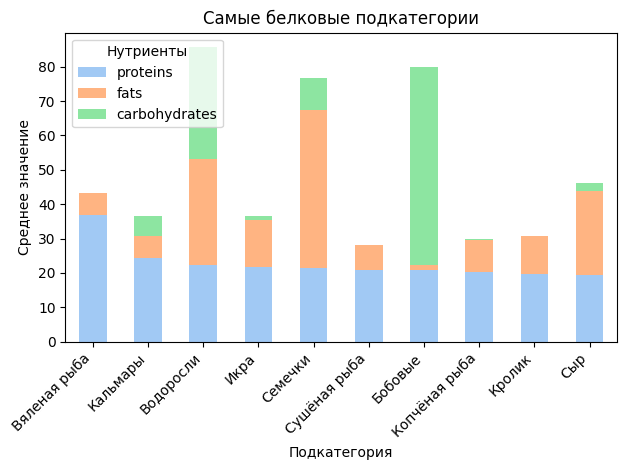

In [677]:
nutrients_by_subcategory = df.groupby('subcategory')[['proteins', 'fats', 'carbohydrates']] \
    .mean().sort_values(by='proteins', ascending=False).head(10)

plt.figure(figsize=(12, 8))
nutrients_by_subcategory.plot(kind='bar', stacked=True)
plt.title('Самые белковые подкатегории')
plt.xlabel('Подкатегория')
plt.ylabel('Среднее значение')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Нутриенты', loc='upper left')
plt.tight_layout()
plt.show()

## Создание новых признаков

In [678]:
from sklearn.feature_extraction.text import HashingVectorizer

import country_data

`is_by_weight` - На развес ли продукт \
`is_special_offer` - Есть ли специальное предложение \
`composition[128]` - Состав в векторном представлении  

`storage_temp_range` - Диапазон температур хранения \
`protein_to_carb_ratio` - Соотношение белков к углеводам \
`is_low_carb` - Является ли продукт низкоуглеводным 

`kalories_all` - Общее количество калорий \
`proteins_all` - Общее количество белков \
`fats_all` - Общее количество жиров 

`is_local` - Из России ли продукт \
`country_gdp_per_capita` - ВВП на душу населения страны

Признаки [is_by_weight](#is_by_weight) и [is_special_offer](#is_special_offer) уже были созданы в предобработке, создадим остальные

**Шаг 1** \
Представим состав в векторном представлении с помощью HashingVectorizer

In [679]:
lines = df['composition'][~df['composition'].isnull()]
vectorizer = HashingVectorizer(n_features=128)
composition_vectors = vectorizer.fit_transform(lines).toarray()

`composition_vectors` оставим в виде переменной для удобства

**Шаг 2** \
Создадим `storage_temp_range`, `protein_to_carb_ratio` и `is_low_carb`. \
Считаем продукт низкоуглеводным, если отношение белков к углеводам больше 1

In [680]:
def calculate_ratio(proteins, carbs):
    if carbs == 0:
        if proteins == 0:
            return 0.0  # NaN
        else:
            return 1e6  # inf 
    return proteins / carbs

df["storage_temp_range"] = df["max_storage_temperature"] - df["min_storage_temperature"]

df["protein_to_carb_ratio"] = df.apply(
    lambda row: calculate_ratio(row["proteins"], row["carbohydrates"]), axis=1
)

df["is_low_carb"] = df["protein_to_carb_ratio"] > 1

**Шаг 3** \
Создадим `kalories_all`, `proteins_all` и `fats_all`

In [681]:
df['kalories_all'] = df['kalories']/100 * df['size']
df['proteins_all'] = df['proteins']/100 * df['size']
df['fats_all'] = df['fats']/100 * df['size']

**Шаг 4** \
`country_gdp_per_capita` получим с помощью функции из `country_data`.\
`is_local` считаем всё что из России

In [682]:
df['is_local'] = df['country'] == "Россия"

df['country_gdp_per_capita'] = df['country'].apply(
    country_data.get_country_gdp_per_capita
).astype(float)

**Итог** \
Мы создали все новые признаки

In [683]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12399 entries, 0 to 12598
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     12399 non-null  object 
 1   category                 12399 non-null  object 
 2   subcategory              12399 non-null  object 
 3   kalories                 12399 non-null  float64
 4   proteins                 12399 non-null  float64
 5   fats                     12399 non-null  float64
 6   carbohydrates            12399 non-null  float64
 7   composition              12399 non-null  object 
 8   manufacturer             12399 non-null  object 
 9   brand                    12399 non-null  object 
 10  country                  12399 non-null  object 
 11  rating                   12399 non-null  float64
 12  size                     12399 non-null  float64
 13  price                    12399 non-null  float64
 14  old_price                12

## Гипотезы

In [684]:
import statsmodels.api as sm
from scipy import stats

Во время работы над проектом у нас возникло несколько вопросов: 
- Влияет ли состав на оценку товара?
- Количество белков зависит от того на развес ли товар?
- Цена зависит от срока хранения?
- Больше ли стоят зарубежные товары?
- Правда ли, что скидки появляются реже у продуктов с маленьким сроком хранения?

**Шаг 1** \
Влияет ли состав на оценку товара?

$$
\begin{aligned}
&H_0: \text{Состав не влияет на оценку товара} \\ 
&H_1: \text{Состав влияет на оценку товара}
\end{aligned}
$$
Применим регрессионный анализ

In [685]:
X = sm.add_constant(composition_vectors)
y = df['rating']

model = sm.OLS(y, X).fit()
p_values = model.pvalues[1:] 

alpha = 0.05

is_p_value_alpha = [p_value < alpha for p_value in p_values]
print('Колличество p_value < alpha:', sum(is_p_value_alpha), "/", len(is_p_value_alpha))

# Если хотя бы одно p-значение меньше alpha, отвергаем H0
if any(is_p_value_alpha):
    print("Гипотеза H0 отвергается: состав влияет на оценку товара")
else:
    print("Гипотеза H0 не отвергается: состав не влияет на оценку товара")

Колличество p_value < alpha: 36 / 128
Гипотеза H0 отвергается: состав влияет на оценку товара


**Шаг 2** \
Количество белков зависит от того на развес ли товар?
$$
\begin{aligned}
&H_0: \text{Количество белков не зависит от того на развес ли товар} \\ 
&H_1: \text{Количество белков зависит от того на развес ли товар}
\end{aligned}
$$
Воспользуемся t-тестом так как значения белков не имеет нормального распределения

In [686]:
proteins_by_weight = df[df['is_by_weight'] == 1]['proteins']
proteins_not_by_weight = df[df['is_by_weight'] == 0]['proteins']

t_stat, p_value = stats.ttest_ind(proteins_by_weight, proteins_not_by_weight, equal_var=False)

print("t-значение:", t_stat)
print("p-значение:", p_value)

alpha = 0.05

if p_value < alpha:
    print("Гипотеза H0 отвергается: количество белков зависит от того, на развес ли товар")
else:
    print("Гипотеза H0 не отвергается: количество белков не зависит от того, на развес ли товар")

t-значение: 22.91666008518203
p-значение: 1.7609782281645117e-88
Гипотеза H0 отвергается: количество белков зависит от того, на развес ли товар


**Шаг 3** \
Цена зависит от срока хранения?
$$
\begin{aligned}
&H_0: \text{Цена не зависит от срока хранения} \\ 
&H_1: \text{Цена зависит от срока хранения}
\end{aligned}
$$Данные не подчиняются нормальному распределению и содержат выбросы, поэтому мы прибегаем к использованию коэффициента корреляции Спирмена 

In [687]:
corr_test = stats.spearmanr(df['shelf_life'], df['price'])
correlation_coefficient = corr_test[0]
p_value = corr_test[1]

print("Коэффициент корреляции Спирмена:", correlation_coefficient)
print("p-значение:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Гипотеза H0 отвергается: цена зависит от срока хранения.")
else:
    print("Гипотеза H0 не отвергается: цена не зависит от срока хранения.")

Коэффициент корреляции Спирмена: 0.29277953461420597
p-значение: 1.375075773286665e-243
Гипотеза H0 отвергается: цена зависит от срока хранения.


**Шаг 4** \
Больше ли стоят зарубежные товары?
$$
\begin{aligned}
&H_0: \text{Зарубежные товары стоят не дороже местных} \\ 
&H_1: \text{Зарубежные товары стоят дороже местных}
\end{aligned}
$$
U-тест является более подходящим методом для задачи чем z-тест, поскольку он не требует нормальности распределения данных и подходит для анализа данных с выбросами. \
Также он подходит для анализа данных с асимметричным распределением

In [688]:
not_unk = ~(df['country'] == "Unknown")

foreign_prices = df[~df['is_local'] & not_unk]['price']
local_prices = df[df['is_local'] & not_unk]['price']

foreign_prices.shape, local_prices.shape

((2635,), (9527,))

In [689]:
u_stat, p_value = stats.mannwhitneyu(foreign_prices, local_prices, alternative='greater')

print("U-статистика:", u_stat)
print("p-значение:", p_value)

alpha = 0.05
if p_value_u < alpha:
    print("Гипотеза H0 отвергается: зарубежные товары стоят больше местных")
else:
    print("Гипотеза H0 не отвергается: зарубежные товары не стоят больше местных")

U-статистика: 18230106.0
p-значение: 6.681267266258801e-278
Гипотеза H0 не отвергается: зарубежные товары не стоят больше местных


**Шаг 5** \
Правда ли, что скидки появляются реже у продуктов с маленьким сроком хранения?

$$
\begin{aligned}
&H_0: \text{Продукты с маленьким сроком хранения не получают скидки чаще, чем остальные продукты} \\ 
&H_1: \text{Продукты с маленьким сроком хранения получают скидки чаще, чем остальные продукты}
\end{aligned}
$$

In [690]:
discounted = df[df['discount'] > 0]['shelf_life']
not_discounted = df[df['discount'] == 0]['shelf_life']

u_stat, p_value = stats.mannwhitneyu(discounted, not_discounted, alternative='greater')

print("U-статистика:", u_stat)
print("p-значение:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Гипотеза H0 отвергается: скидки чаще появляются у продуктов с большим сроком хранения")
else:
    print("Гипотеза H0 не отвергается: скидки не появляются чаще у продуктов с большим сроком хранения")

U-статистика: 17661316.5
p-значение: 2.3882945670061588e-57
Гипотеза H0 отвергается: скидки чаще появляются у продуктов с большим сроком хранения


## Машинное обучение

In [691]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

**Шаг 1** \
Попробуем предсказать цену товара на основе его характеристик. \
Это может быть полезно для производителей, желающих определить стоимость своей продукции

In [692]:
features = [
    "kalories",
    "proteins",
    "fats",
    "carbohydrates",
    "rating",
    "size",
    "discount",
    "shelf_life",
    "max_storage_temperature",
    "min_storage_temperature",
    "is_by_weight",
    "is_special_offer",
    "storage_temp_range",
    "protein_to_carb_ratio",
    "is_low_carb",
    "kalories_all",
    "proteins_all",
    "fats_all",
    "country_gdp_per_capita",
]

one_hot_features = ["category", "subcategory", "country"]

target = "price"

X = df[features]
X = np.concatenate((X, composition_vectors), axis=1)

df_one_hot = pd.get_dummies(df[one_hot_features])
X = np.concatenate((X, df_one_hot), axis=1)

y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7
)

Исключаем ненужные столбцы, такие как `name`, а также категориальные столбцы `manufacturer` и `brand`, чтобы новые производители могли опираться только на характеристики продукта при оценке его стоимости

**Шаг 2** \
Обучим несколько моделей регрессии

In [693]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

predictions = linear_regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print("LinearRegression")
print("Среднеквадратичная ошибка на тестовом наборе:", mse)

LinearRegression
Среднеквадратичная ошибка на тестовом наборе: 159740.22830162052


In [694]:
knn_regressor = KNeighborsRegressor()
knn_regressor.fit(X_train, y_train)

predictions = knn_regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print("KNeighborsRegressor")
print("Среднеквадратичная ошибка на тестовом наборе:", mse)

KNeighborsRegressor
Среднеквадратичная ошибка на тестовом наборе: 172826.62168430001


In [695]:
gb_regressor = GradientBoostingRegressor(random_state=7)
gb_regressor.fit(X_train, y_train)

predictions = gb_regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print("GradientBoostingRegressor")
print("Среднеквадратичная ошибка на тестовом наборе:", mse)

GradientBoostingRegressor
Среднеквадратичная ошибка на тестовом наборе: 124951.66802139686


In [696]:
rf_regressor = RandomForestRegressor(random_state=7)
rf_regressor.fit(X_train, y_train)

predictions = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print("RandomForestRegressor")
print("Среднеквадратичная ошибка на тестовом наборе:", mse)

RandomForestRegressor
Среднеквадратичная ошибка на тестовом наборе: 98544.6360533836


**Итог** \
Лучший результат MSE показал RandomForest

In [697]:
_, X_test, _, _ = train_test_split(
    df[['name', 'price']], y, test_size=0.2, random_state=7
)
df_comparison = pd.DataFrame({'Название': X_test['name'], 'Реальная Цена': X_test['price'], 'Предсказание': predictions})
df_comparison.head(10)

,Название,Реальная Цена,Предсказание
6018,Напиток спиртной Ron Calados Карибиан Спайсд 3...,999.99,2996.4495
2605,Макароны Pasteroni Tortoglioni №127 группа А в...,69.99,72.8400
3799,Сыр мягкий Schonfeld Blue с голубой плесенью 54%,2199.00,1180.8088
9600,Печенье Ванюшкины Сладости Орешки из детства с...,249.99,324.5975
1178,"Хаш Ecofood Армянский, 525г",279.99,415.9477
11964,"Пицца Zotman Ice Баварская мясная, 465г",559.99,348.2900
3648,"Сыр Пармезан Deluxe 34%, 200г",389.99,292.6373
3062,"Бульон Maggi с лесными грибами в кубиках, 72г",47.99,72.0100
4842,Сливки Ehrmann питьевые ультрапастеризованные ...,65.99,62.6567
11263,Печенье ProteinRex Флепджек овсяное протеиново...,114.99,97.2992
